 **IMPORT LIBRARY**

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


**INSTALL KAGGLE**

In [2]:
! pip install -q kaggle

**IMPORT FILES FROM GCOLLAB ADD API KAGGLE**

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nurihidayatuloh","key":"3559ca31cfd3cf9425c72958ed641d67"}'}

In [4]:
!chmod 600 /content/kaggle.json

In [69]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 665M/675M [00:08<00:00, 65.2MB/s]
100% 675M/675M [00:08<00:00, 78.7MB/s]


**UNZIPPING FILE**

In [71]:
import os, zipfile
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content') #unzip atau mengekstrak file zip dataset
zip_ref.close()

In [72]:
base_dir = '/content/cell_images'

**MENYIAPKAN DATA**

In [77]:
import numpy as np
import pandas as pd

def data_prep(parasitized,uninfected):

    parasitized= ["/content/cell_images/Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected= ["/content/cell_images/Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized)*['Terinfeksi'] + len(uninfected)*['Tidak Terinfeksi']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('/content/cell_images/Parasitized/'), os.listdir('/content/cell_images/Uninfected/'))
df.head()

,Image_Path,Labels
0,/content/cell_images/Parasitized/C166P127ThinF...,Terinfeksi
1,/content/cell_images/Parasitized/C140P101ThinF...,Terinfeksi
2,/content/cell_images/Parasitized/C188P149ThinF...,Terinfeksi
3,/content/cell_images/Parasitized/C91P52ThinF_I...,Terinfeksi
4,/content/cell_images/Parasitized/C68P29N_ThinF...,Terinfeksi


**MENAMPILKAN GAMBAR SESUAI DENGAN KELAS**

Menampilkan 5 Gambar yang Terinfeksi: 



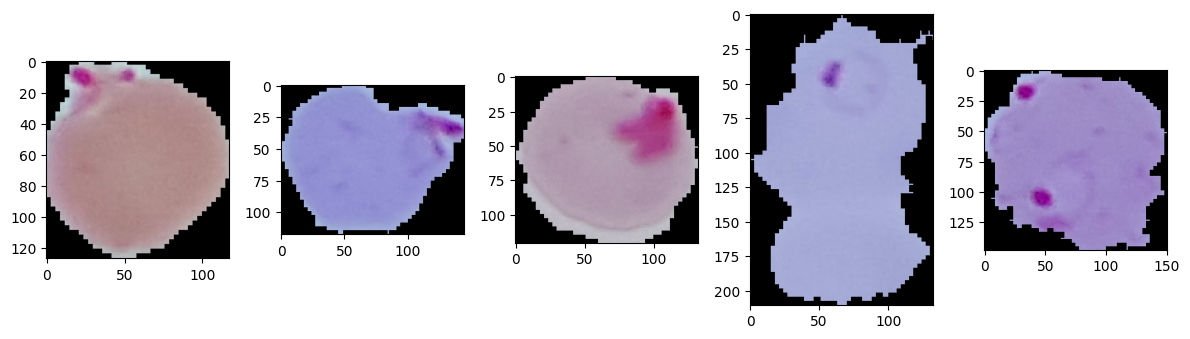


Menampilkan 5 Gambar yang Tidak Terinfeksi: 



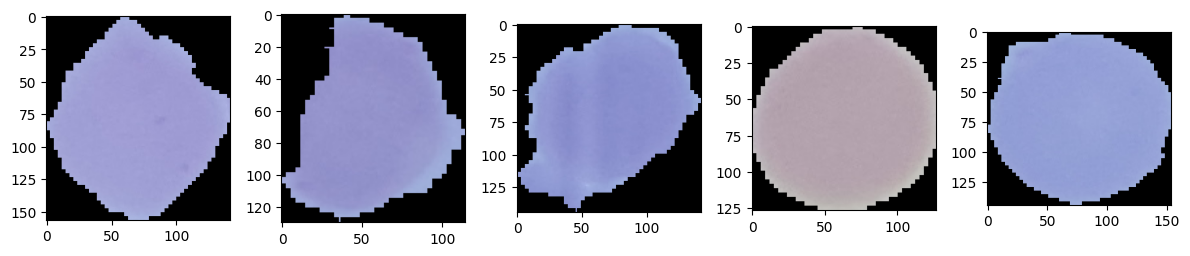

In [79]:
import matplotlib.pyplot as plt
import cv2

print("Menampilkan 5 Gambar yang Terinfeksi: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'Terinfeksi']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Menampilkan 5 Gambar yang Tidak Terinfeksi: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'Tidak Terinfeksi']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()

**VISUALISASI GRAFIK BATANG PERSEBARAN TIAP KELAS**

Text(0.5, 1.0, 'Distribution of samples according to the categories')

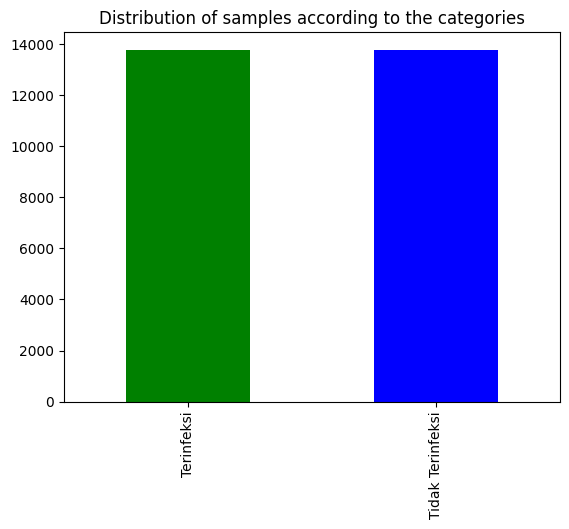

In [80]:
df['Labels'].value_counts().plot(kind = 'bar', color = ['green', 'blue'])
plt.title('Distribution of samples according to the categories')

**AUGMENTASI DATA**

In [81]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2)

class stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      print('\nAkurasi sudah melampaui 92%')
      self.model.stop_training = True

my_callbacks = [
    EarlyStopping(patience=2),
    stop()
]

In [83]:
train.shape

(22048, 2)

In [84]:
test.shape

(5512, 2)

**SPLITTING**

In [97]:
import warnings
warnings.filterwarnings('ignore')

x_train =  img_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='Image_Path',
    y_col='Labels',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False,
    batch_size=10,
    seed=10,
    subset='training')

x_val = img_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='Image_Path',
    y_col='Labels',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False,
    batch_size=10,
    seed=10,
    subset='validation')

Found 17638 validated image filenames belonging to 2 classes.
Found 4409 validated image filenames belonging to 2 classes.


**ARSITEKTUR MODEL**

In [98]:
from keras import models
from keras import layers
from keras.applications import resnet50
from keras.models import *
from keras.layers import *
import keras

def my_model(df, x_train, x_val, my_callbacks):
    model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1024, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model.fit(x_train,
                            validation_data=x_val,
                            epochs = 4, callbacks=my_callbacks)

    return model_history, model

history_model,models = my_model(df, x_train, x_val, my_callbacks)

Epoch 1/4
1764/1764 [==============================] - 284s 160ms/step - loss: 0.7582 - accuracy: 0.7487 - val_loss: 0.2089 - val_accuracy: 0.9340
Epoch 2/4
1764/1764 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9286
Akurasi sudah melampaui 92%
1764/1764 [==============================] - 283s 160ms/step - loss: 0.2484 - accuracy: 0.9286 - val_loss: 0.1814 - val_accuracy: 0.9422


**VISUALISASI PLOT AKURASI DAN LOSS**

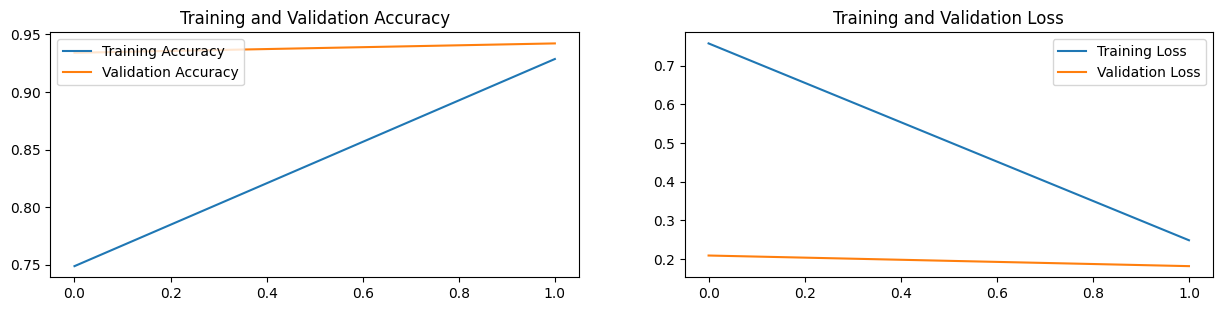

In [99]:
accuracy = history_model.history['accuracy']
loss = history_model.history['loss']
validation_loss = history_model.history['val_loss']
validation_accuracy = history_model.history['val_accuracy']

plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(len(accuracy)), loss, label='Training Loss')
plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

**SAVE MODEL DALAM BENTUK TF-Lite**

In [100]:
# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with tf.io.gfile.GFile('model-proyek-akhir.tflite', 'wb') as f:
  f.write(tflite_model)

In [101]:
from google.colab import files

# Downloadmodel
files.download('/content/model-proyek-akhir.tflite')

print('`model-proyek-akhir.tflite` sudah berhasil didownload')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model-proyek-akhir.tflite` sudah berhasil didownload
